# Example 3: Inverse estimation of soil hydraulic properties using pHydrus and MCMC 
*Authors: G. Brunetti, R.A. Collenteur, and M. Vremec, 2021*

---
This notebook is part of a manuscript that is currently being prepared (summer 2021): 

*R.A. Collenteur, M. Vremec, J. Simunek, and G. Brunetti, (in preparation) pHydrus: an open source Python package for the Hydrus-1D model.*

---

In this Notebook the model constructed in the previous example is extended for inverse estimation of soil hydrauilic properties 

1. generation of Synthethic Data by forward simulation 
2. inverse estimation of soil hydraulic properties

---
In this notebook it is shown how the MCMC-algorithm can be used to estimate the soil hydrauilic properties for a Phydrus model. Apart from pHydrus being installed, the following Python Packages have to be installed:

- [emcee](https://emcee.readthedocs.io/en/stable/user/faq/)
- [corner](https://corner.readthedocs.io)

### 1. Import the Pydrus package

In [1]:
# Import the Python packages used
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import emcee
import corner

import phydrus as ps

ps.set_log_level("ERROR")

run_mcmc = True

ps.show_versions()

### 2.Create a pHydrus model
In the following code block we create a simple pHydrus model similar to that developed in Example 1, but with only one soil layer.

In [2]:
# Folder where the Hydrus files are to be stored
ws = "output"
exe = os.path.join(os.getcwd(), "../hydrus_mcmc")

# Create model
ml = ps.Model(exe_name=exe, ws_name=ws)

ml.add_time_info(tinit=0, tmax=730, print_times=True)
ml.add_waterflow(model=0, top_bc=3, bot_bc=4)

# Add materials
m = ml.get_empty_material_df(n=1)
m.loc[0:1] = [[0.0, 0.34, 0.01, 1.47, 13, 0.5]]
ml.add_material(m)

bottom = -100  # Depth of the soil column
ihead = -500  # Determine initial pressure head

profile = ps.create_profile(bot=bottom, dx=1, h=ihead, mat=1)
ml.add_profile(profile)
ml.add_obs_nodes([-50])

atm = pd.read_csv("../data/atmosphere.csv", index_col=0)
ml.add_atmospheric_bc(atm, hcrits=0)

Check the time it takes to write the input files:

In [3]:
%%timeit
ml.write_input()

83.3 ms ± 610 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


And the time to run the Hydrus-1D simulation:

In [4]:
%%timeit
ml.simulate()

120 ms ± 616 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 3. Create synthetic data

In [5]:
df = ml.read_obs_node()
vwc_1=df[ml.obs_nodes[0]].loc[:,'theta']

# Add gaussian noise
np.random.seed(0)
std = 0.005
g_noise = np.random.normal(0, std, len(vwc_1))
synth_vwc = vwc_1 + g_noise

Text(0, 0.5, '$\\Theta_{w}$ [-]')

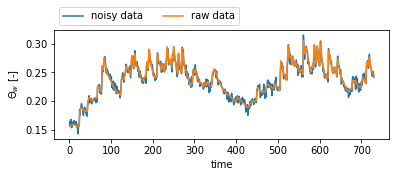

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 2), sharey=True)

synth_vwc.plot(ax=ax1, label="noisy data")
vwc_1.plot(ax=ax1, label="raw data")
ax1.legend(ncol=2, bbox_to_anchor=[0,1], loc=3)
ax1.set_ylabel("$\Theta_{w}$ [-]")

### 4. Use EMCEE for inverse estimation: Function Definition

In [7]:
# Prior
def lnprior_uniform(params, bounds):
    if np.any(params < bounds[:,0]) or np.any(params > bounds[:,1]):
        return -np.inf
    else:
        return 0

    
# Gaussian Log-Likelihood
def lnlike(params, synth):
    # Update hydraulic parameters
    thS, a, n, Ks, l, sigma = params
    ml.materials.iloc[:, 1:] =[[thS, a, n, Ks, l]]
    ml.write_selector() 
    ml.simulate()
    
    # Read simulated WVC from file
    obs = ml.read_obs_node()
    mod = obs[ml.obs_nodes[0]].loc[:,'theta']
    
    # Check if Hydrus-1D converged
    if len(mod) < len(synth):
        #print ("Hydrus-1D did not converge")
        SSQ = 1e+7
    else:
        SSQ = ((mod - synth)**2).sum()

    N = synth.size
    
    lnlike = -0.5 * N * np.log(2 * np.pi) - 0.5 * N * \
             np.log(sigma**2) / -(0.5 / sigma**2) * SSQ

    return lnlike


# Full Log-Probability
def lnprob(params, synth, bounds):
    lp = lnprior_uniform(params, bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(params, synth)

### 5. Run MCMC Analysis

In [8]:
# UNCERTAINTY ANALYSIS
truth = [0.34, 0.01, 1.47, 13, 0.5, 0.005]
lb = np.array([0.25, 0.001, 1.1, 1, -1, 0])
ub = np.array([0.45, 0.1, 2, 100, 3, 0.05])
bounds = np.vstack([lb,ub]).T

ndim = len(bounds)
nwalkers = 50
filename = "MCMC_test.h5"

backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, backend=backend,
                                args=[synth_vwc, bounds], a=2.)
p0 = emcee.utils.sample_ball(
    [0.34, 0.03, 1.7, 15, 0.1, 0.007],
    [0.001] * ndim, size=nwalkers)

truth = np.append(m.iloc[:, 1:].to_numpy(), std)

# Only run if run_mcmc equals True
if run_mcmc is True:
    sampler.run_mcmc(p0, 2000, progress=True)
    print(lnlike(truth, synth_vwc))

100%|██████████| 2000/2000 [4:57:12<00:00,  8.92s/it]   

-670.8286770661051


### 6. Visualize the results
Corner is a simple but great python package that makes creating corner graphs easy. One line of code suffices to create a plot of the parameter distributions and the covariances between the parameters. 

In [9]:
reader = emcee.backends.HDFBackend(filename, read_only=True)
walkers = reader.get_chain(flat=False)
chains = reader.get_chain(discard=1500,flat=True)

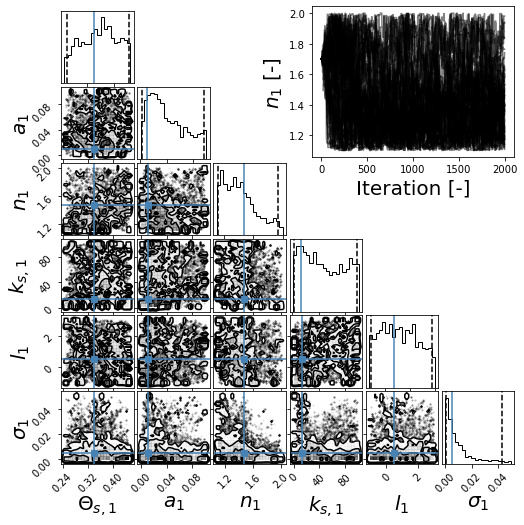

In [10]:
labels = ["$\Theta_{s,1}$", "$a_1$", "$n_1$", "$k_{s,1}$", "$l_1$", "$\sigma_1$"]

# Make corner plot
fig = plt.figure(figsize=(7, 7))
axes = corner.corner(chains, quantiles=[0.025, 0.975], truths=truth, fig=fig, labelpad=0.1,
                     labels=labels, label_kwargs=dict(fontsize=20), max_n_ticks=3);

# Show walkers for parameter X
ax2 = plt.axes([0.57, 0.68, 0.4, 0.3])
plt.plot(walkers[:, :, 2], color="k", alpha=0.5);
plt.ylabel('$n_{1}$ [-]', fontsize=20)
plt.xlabel('Iteration [-]', fontsize=20);
plt.savefig("../figures/figure_4.pdf", bbox_inches="tight", dpi=300)

### 7. Mean Acceptance Rate

In [11]:
acc_frac = np.mean(reader.accepted / reader.iteration)
print("The mean acceptance rate is:", acc_frac)

The mean acceptance rate is: 0.25303000000000003
